![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías

# plot
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

# python
import math
import pandas as pd
import numpy as np

# regressor models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# sklearn
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

# data processing
from sklearn import metrics
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
#Analisis descriptivo de la variable predictora
y_test.describe()

count     3464.000000
mean     14599.966224
std       3911.593385
min       5200.000000
25%      11999.000000
50%      15144.500000
75%      17000.000000
max      29975.000000
Name: Price, dtype: float64

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
X_train.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
318288,2014,39988,False,False,False,False,False,True,False
333638,2007,38904,False,False,False,False,True,False,False
234716,2016,29607,False,False,False,False,False,True,False
208752,2014,50756,False,False,False,False,False,True,False
348892,2017,10506,False,False,False,False,False,True,False


In [ ]:
# Celda 1
def tree_nicely(tree):
    import json
    print(json.dumps(tree, indent=4, sort_keys=False))

def mse(y):
    return ((y.mean() - y)**2).mean()

def mse_gain(X_col, y, split):
    # adaptado de
    # https://www.codecademy.com/article/mlfun-decision-trees-article
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    n = n_l + n_r
    w = n_l / n

    current_mse = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)

    return current_mse - w * mse_l - (1 - w) * mse_r


def best_split(X, y, num_pct=10):
    import math
    features = range(X.shape[1])
    best_split = [0, 0, math.inf]  # j, split, mse

    # Para todas las variables
    for j in features:
        splits = np.linspace(X.iloc[:, j].min(), X.iloc[:, j].max(), num_pct)
        splits = np.unique(splits)[1:]

        # Para cada partición
        for split in splits:
            mse = mse_gain(X.iloc[:, j], y, split)

            if mse < best_split[2]:
                best_split = [j, split, mse]

    return best_split

In [ ]:
def tree_grow(X, y, level=0, max_depth=1, num_pct=10):
    import math
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, rmse=math.inf)
        return tree

    # Calcular la mejor división
    j, split, sc_rmse = best_split(X, y, num_pct)

    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()

    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], rmse=sc_rmse)
    # Revisar el criterio de parada
    if max_depth is not None:
        if level >= max_depth:
            return tree

    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, max_depth=max_depth, num_pct=num_pct)

    return tree

In [ ]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree):
    """
    """
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']

    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

In [ ]:
# Modelo Arbol Manual
treg = tree_grow(X_train, y_train, level=0, max_depth=5, num_pct=3)

In [ ]:
# Prediccion y Metricas Arbol Manual
y_pred = tree_predict(X_test, treg)
rmse = metrics.mean_squared_error(y_test, y_pred)**.5
mae = metrics.mean_absolute_error(y_test, y_pred)
rmse, mae

(3906.6898591446447, 3105.392727255433)

In [ ]:
# Benchmark sklearn
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_features="sqrt", max_depth=3)
dtr.fit(X_train, y_train)
y_pred_ = dtr.predict(X_test)
rmse_ = metrics.mean_squared_error(y_test, y_pred)**.5
mae_ = metrics.mean_absolute_error(y_test, y_pred)
rmse_, mae_

(3906.6898591446447, 3105.392727255433)

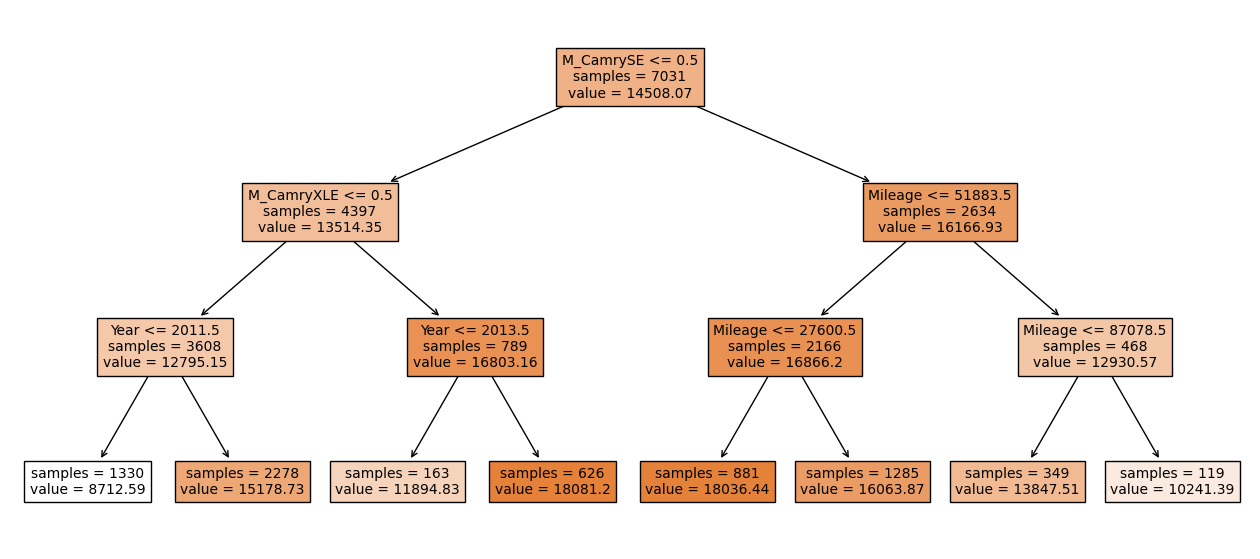

In [ ]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(16, 7))
plot_tree(
    dtr,
    feature_names = X_train.columns.tolist(),
    filled        = True,
    impurity      = False,
    fontsize      = 10,
    precision     = 2,
    ax            = ax
)
plt.show()

Según los resultado del modelo del arbol de regresion RMSE=3906 y MAE=3105 se puede considerar que este modelo no presenta un buen desempeño pues estos resultados tienen valores muy cercanos a la desviacion de esta variable

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2
# Se crea un arreglo de 1 a 20
#np.random.seed(1)

# Impresión de arreglo y muestreo aleatorio
#nums = np.arange(1, 21)
#print('Arreglo:', nums)
#print('Muestreo aleatorio: ', np.random.choice(a=nums, size=20, replace=True))

# Creación de 10 muestras de bootstrap
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 3454, 1346, ...,  826,  801, 5657]),
 array([6962, 3408, 2553, ..., 6611,  877, 6412]),
 array([1917, 3131,  384, ..., 2876, 6449, 6557]),
 array([3849, 4565, 6820, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 3108, 2961, 4357]),
 array([3142, 1537, 5966, ..., 3224, 6922, 3396]),
 array([6588, 3753, 1786, ..., 2131, 4627, 5672]),
 array([1289, 3776,  981, ..., 1891, 6034, 6165]),
 array([6079, 3819, 6976, ..., 6478, 2225, 5072]),
 array([3952, 3276,  896, ..., 4589, 1964,  893])]

In [ ]:
# Visualización muestra boostrap #1 para entremiento
X_train.iloc[samples[0], :]

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
151599,2016,40999,False,False,False,False,False,True,False
171999,2014,52527,False,False,False,False,False,True,False
304172,2009,123202,False,True,False,False,False,False,False
74828,2015,38807,False,False,False,False,False,True,False
192974,2005,51260,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...
134843,2014,22221,False,False,False,False,True,False,False
325075,2013,86593,False,False,False,False,False,True,False
61213,2014,28044,False,False,False,False,False,True,False
181222,2016,49368,False,False,False,False,False,False,True


In [ ]:
# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred_Bag = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_trainBag = X_train.iloc[sample,:]
    y_trainBag = y_train.iloc[sample,]
    treereg.fit(X_trainBag, y_trainBag)
    y_pred_Bag.iloc[:,i] = treereg.predict(X_test)

y_pred_Bag

,0,1,2,3,4,5,6,7,8,9
257343,14980.0,13993.0,13649.0,13649.0,11788.0,13649.0,13993.0,13990.0,13990.0,13993.0
326011,6492.0,5995.0,5995.0,6987.0,5995.0,5995.0,5995.0,6987.0,5995.0,5995.0
242354,16491.0,16995.0,16491.0,15997.0,15997.0,16491.0,17591.0,16995.0,17404.0,16491.0
266376,21990.0,21990.0,22500.0,21990.0,15900.0,21990.0,22500.0,21990.0,15813.0,21990.0
396954,15988.0,16951.0,15988.0,15988.0,15988.0,17900.0,16951.0,16951.0,15988.0,15988.0
...,...,...,...,...,...,...,...,...,...,...
144298,13836.0,14800.0,14800.0,14800.0,14800.0,14681.0,14800.0,14800.0,13836.0,13836.0
364521,15999.0,14995.0,15999.0,16900.0,15999.0,15999.0,17300.0,15999.0,16900.0,15000.0
120072,23533.0,23533.0,20000.0,17700.0,17700.0,23533.0,17700.0,23533.0,23533.0,20000.0
99878,12989.0,12995.0,12989.0,12995.0,12991.0,12991.0,10995.0,12991.0,12991.0,12893.0


In [ ]:
# Desempeño de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_Bag.iloc[:,i])), ' y MAE: ', metrics.mean_absolute_error(y_test, y_pred_Bag.iloc[:,i]))


Árbol  0 tiene un RMSE:  2141.613353645869  y MAE:  1605.3012605850654
Árbol  1 tiene un RMSE:  2136.3519863123465  y MAE:  1589.8544072363356
Árbol  2 tiene un RMSE:  2122.718759132052  y MAE:  1577.7323421862973
Árbol  3 tiene un RMSE:  2087.278992468617  y MAE:  1569.6103493071594
Árbol  4 tiene un RMSE:  2168.518742842026  y MAE:  1614.8178695150114
Árbol  5 tiene un RMSE:  2113.8811455834793  y MAE:  1576.055638953041
Árbol  6 tiene un RMSE:  2127.933470769012  y MAE:  1582.1453521939954
Árbol  7 tiene un RMSE:  2184.414847251443  y MAE:  1606.3077848344878
Árbol  8 tiene un RMSE:  2138.1071697514985  y MAE:  1586.4345169361045
Árbol  9 tiene un RMSE:  2132.097520859104  y MAE:  1587.769866243264


In [ ]:
# Predicciones promedio para cada observación del set de test
y_pred_Bag.mean(axis=1)

257343    13767.4
326011     6243.1
242354    16694.3
266376    20865.3
396954    16468.1
           ...   
144298    14498.9
364521    16109.0
120072    21076.5
99878     12782.0
387162    11957.4
Length: 3464, dtype: object

In [ ]:
# Error al promediar las predicciones de todos los árboles
rmse_Bag= np.sqrt(mean_squared_error(y_test, y_pred_Bag.mean(axis=1)))
mae_Bag= metrics.mean_absolute_error(y_test, y_pred_Bag.mean(axis=1))

rmse_Bag, mae_Bag

(1796.4355868399332, 1340.0160739030025)

Se puede ver el RMSE y el MAE, por si solos no nos dicen mucho, sin embargo, sabemos que entre más bajos sean ambos mejor será el modelo. Con el RMSE que es la raíz cuadrada del promedio de los cuadrados de las diferencias entre los valores predichos y los valores reales. Y el MAE que es la media de las diferencias absolutas entre las predicciones del modelo y los valores reales. Sin embargo, en este contexto donde la variable a predecir es el precio de los carros y presenta una media de 14599 y una desviación de 3911 podríamos considerar que este modelo presenta un buen desempeño pues el RMSE y el MAE tiene valores de 1796 y 1340 respectivamente por lo que esto indica que las predicciones se desvían en promedio del precio real en valores que son menores que la desviación

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3

# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X_train.shape[1]+1)

rmse_Bag_scores=[]
msa_Bag_scores=[]

for n_features in feature_range:
  max_features=max(1,int(np.log(n_features)))
  print(np.log(n_features))

  bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10, max_features=max_features, bootstrap=True, oob_score=True, random_state=1)
  # Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
  bagreg.fit(X_train, y_train)
  y_pred_Bag2 = bagreg.predict(X_test)
  rmse_Bag_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_Bag2)))
  msa_Bag_scores.append(metrics.mean_absolute_error(y_test, y_pred_Bag2))


0.0
0.6931471805599453
1.0986122886681098
1.3862943611198906
1.6094379124341003
1.791759469228055
1.9459101490553132
2.0794415416798357
2.1972245773362196


Text(0, 0.5, 'RMSE')

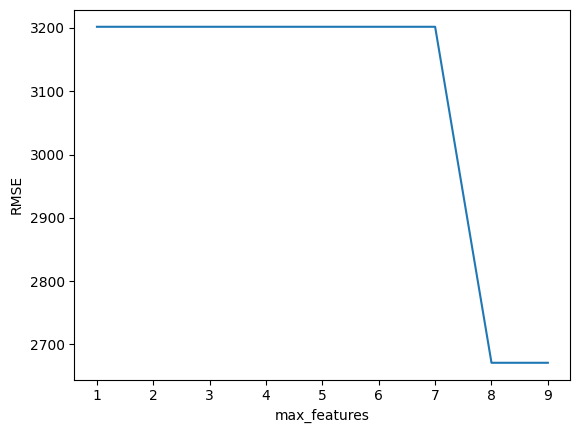

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, rmse_Bag_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE')

In [ ]:
#Seleccion del numero optimo de max features
max_features = max(1,int(np.log(8)))

bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10, max_features=max_features, bootstrap=True, oob_score=True, random_state=1)
# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred_Bag2 = bagreg.predict(X_test)
rmse_Bag2=np.sqrt(mean_squared_error(y_test, y_pred_Bag2))
mae_Bag2=metrics.mean_absolute_error(y_test, y_pred_Bag2)

rmse_Bag2, mae_Bag2

(2671.0127988157697, 2074.9760882251453)

Como se puede observar en la grafica, al usar usando logaritmo en la seleccion de la cantidad de variables a usar, el RMSE en el rango de max_features: 1 a 7 es igual ya que para este el resultado del logaritmo es 1, mientras que en el rango de 8-9 el RMSE disminuye pues el resultado del logaritmo cambia a 2, por lo que el por lo que el numero de variables optimo es 8 pues este es el punto en donde si se selecciona un numero mayor de variables no brindaria ninguna mejora en los resultados del modelo.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4
# Random Forest: Sin calibrar
rfreg = RandomForestRegressor()
rfreg.fit(X_train, y_train)
y_pred_rfreg = rfreg.predict(X_test)

rmse_rfreg = metrics.mean_squared_error(y_test, y_pred_rfreg)**.5
mae_rfreg = metrics.mean_absolute_error(y_test, y_pred_rfreg)
r2_rfreg = r2_score(y_test, y_pred_rfreg)

print(f'RMSE: {rmse_rfreg}, MAE: {mae_rfreg}, R2 Score: {r2_rfreg}')

RMSE: 1760.8377893184654, MAE: 1311.3960857495163, R2 Score: 0.7972986291253501


Se aprecia que el modelo tiene un RMSE de 1760.83, por si sola esta una metrica no indica mucho. Un RMSE más bajo acota un mejor ajuste del modelo a los datos, en ese sentido resulta mejor que el bagging y el arbol de decision de los puntos anteriores (cuantan con un RMSE mayor)

Por otro lado el $R^2$ de 0.797 sugiere que alrededor del 79.7% de la variabilidad en la variable dependiente está explicada por el modelo.

Finalmente el MAE de 1311.39, al medir la media de las diferencias absolutas entre las predicciones del modelo y los valores reales, sugiere que si tiende a cero es mejor, en este caso el MAE, en ese sentido resulta mejor que el bagging y el arbol de decision de los puntos anteriores (cuantan con un MAE mayor o más lejano al cero)


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Random Forest: Calibrar
# buscar mediante una grilla los hiperparametros del modelo
seed = 123
n_features = X_train.shape[1]
hyper_params=dict(
    estimator__max_depth=[3, 4, 5],
    estimator__max_features=range(int(n_features/3), n_features+1), # p/3 > m > p
    estimator__n_estimators=[100, 200, 300]
)

model_cv_rfreg = GridSearchCV(
    estimator=RFE(RandomForestRegressor()),
    param_grid=hyper_params,
    cv=KFold(n_splits=5, shuffle=True, random_state=seed),
    scoring='neg_mean_squared_error',
    verbose=1,
    return_train_score=True
)

# ver como se sobreescribiran los paramatros
# del modelo RandomForestRegressor mediante el GridSearchCV
# model_cv_rfreg.get_params()

In [ ]:
# lanzar proceso entrenamiento para la busqueda de parametros en la grilla
# Fitting 5 folds for each of 63 candidates, totalling 315=3*7*3*5 fits
model_cv_rfreg.fit(X_train, y_train)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=RFE(estimator=RandomForestRegressor()),
             param_grid={'estimator__max_depth': [3, 4, 5],
                         'estimator__max_features': range(3, 10),
                         'estimator__n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [ ]:
# se genera un reporte con las métricas correspondietes al proceso anterior
cv_rfreg_results = pd.DataFrame(model_cv_rfreg.cv_results_)

# se indica los campos que tiene el reporte de interes
# cv_rfreg_results.columns

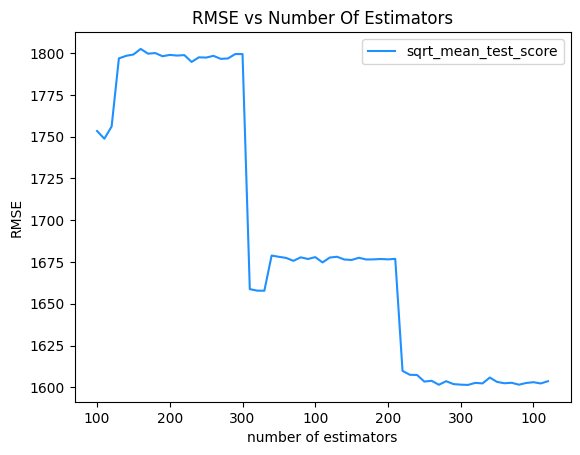

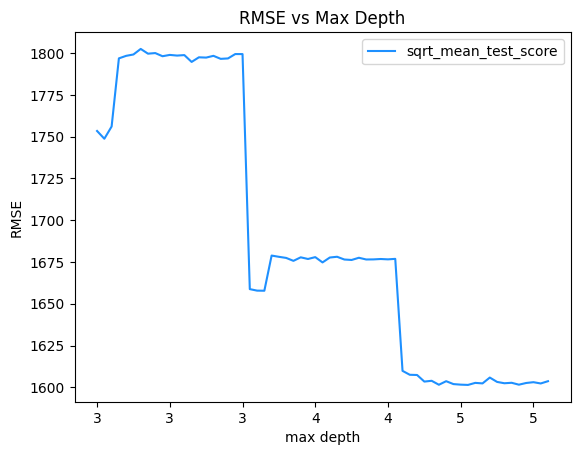

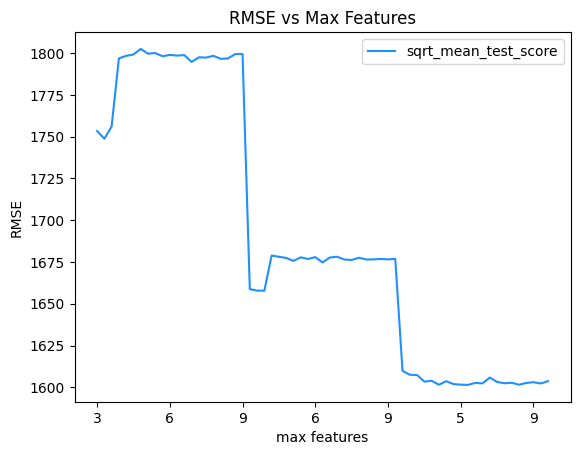

In [ ]:
# se renderiza el numero de estimadores, profundidad maxima y
# cantidad maxima de caracteristicas vs RMSE para ver cuales
# son los parametros que la minimizan (RMSE) en este caso
# solo para el test
def plot_line(df,param,xlabel):
    (
        df
            .loc[:, [param, "mean_test_score"]]
            .reset_index()
            .assign(sqrt_mean_test_score=lambda col:np.sqrt(col.mean_test_score*-1))
    ).plot(
        x=param,
        y='sqrt_mean_test_score',
        title=f'RMSE vs {xlabel.title()}',
        xlabel=xlabel,
        ylabel='RMSE',
        color='dodgerblue'
    )

plot_line(cv_rfreg_results, 'param_estimator__n_estimators', 'number of estimators')
plot_line(cv_rfreg_results, 'param_estimator__max_depth', 'max depth')
plot_line(cv_rfreg_results, 'param_estimator__max_features', 'max features')

In [ ]:
# seleccionar los mejores paramatros
# que se evidenciaron previamente en los 3 graficos de arriba
# Estos son la mezcla de los 315 ajustes que se hicieron
model_cv_rfreg.best_params_
best_params = {
    k.replace('estimator__', ''):v
    for k, v in model_cv_rfreg.best_params_.items()
}
best_params

{'max_depth': 5, 'max_features': 6, 'n_estimators': 100}

In [ ]:
# Random Forest Calibrado con los Mejores Parametros Encontrados en la Grilla
rfregTuning = RandomForestRegressor(**best_params)
rfregTuning.fit(X_train, y_train)
y_pred_rfregt = rfregTuning.predict(X_test)

rmse_rfregt = metrics.mean_squared_error(y_test, y_pred_rfregt)**.5
mae_rfregt = metrics.mean_absolute_error(y_test, y_pred_rfregt)
r2_rfregt = r2_score(y_test, y_pred_rfregt)

print(f'RMSE: {rmse_rfregt}, MAE: {mae_rfregt}, R2 Score: {r2_rfregt}')

RMSE: 1610.5695125731345, MAE: 1193.9618274476256, R2 Score: 0.8304191009415186


Las 2 metricas RMSE, MAE del random forest calibraro tuvieron una mejora con respecto al random forest sin calibrar (el $R^2$ se mantuvo). Pero es importante acotar que estos resultados no necesariamente son los óptimos, porque están condicionadas al rango que se le dio inicialmente a los parámetros max_depth (3 configuraciones), max_features (7 configuraciones) y n_estimators (3 configuraciones).

Lo anterior implica que efecturaron 315 ajustes de las 63 (3 * 7 * 3) combinaciones (o candidatos) previamente acotados, en tal sentido podría existir otro conjunto de candidatos que mejore las métricas RMSE, MAE, por tanto la calibración termina siendo costosa computacionalmente hablando.

>Nota: En el caso de `max_features` se empleo lo siguiente $p/3 \geq m \geq p$, esto ayuda a limitar la busqueda también de parámetros

### Manera Manual

#### Calibracion estimators

In [ ]:

estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
mse_scores_n_estimators = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    RF_Reg = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    cross_val=cross_val_score(RF_Reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    mse_scores_n_estimators.append(cross_val)

Text(0, 0.5, 'Negative MSE')

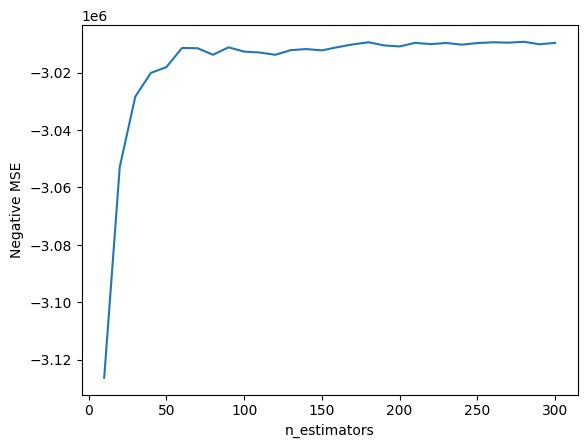

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, mse_scores_n_estimators)
plt.xlabel('n_estimators')
plt.ylabel('Negative MSE')

Al parecer viendo la grafica se llega a un punto maximo en 50 o mas adelante, pero pasando 50 no se ve una mejora significativa

#### Calibracion max_features

In [ ]:
feature_cols=X.columns
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
mse_scores_max_features = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestRegressor(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    cross_val=cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    mse_scores_max_features.append(cross_val)

Text(0, 0.5, 'Accuracy')

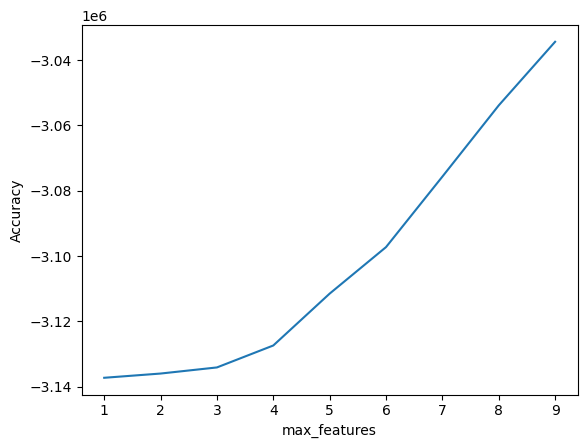

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, mse_scores_max_features)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()
xgb_reg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_reg.fit(X_train, y_train)
y_pred=xgb_reg.predict(X_test)
XGb_sin_mse=mean_squared_error(y_pred, y_test.values)
XGb_sin_r2=r2_score(y_pred, y_test.values)
XGb_sin_mae=mean_absolute_error(y_pred, y_test.values)

print(f'MSE: {XGb_sin_mse}, R2 Score: {XGb_sin_r2}, MAE: {XGb_sin_mae}')

MSE: 2576781.074646859, R2 Score: 0.8038713350750613, MAE: 1185.2272991506386


Como se puede ver el modelo tiene un MSE de 2576781.07, lo que por si solo no dice mucho pero es una metrica que mide el promedio de los cuadrados de las diferencias entre los valores predichos y los valores reales. Un MSE más bajo indica un mejor ajuste del modelo a los datos.,

 Tambien vemos un $R^2$ de 0.8039 esto sugiere que alrededor del 80.39% de la variabilidad en la variable dependiente está explicada por el modelo.

Finalmente se ve un MAE de 1185.23, el MAE es la media de las diferencias absolutas entre las predicciones del modelo y los valores reales. Al igual que el MSE, un MAE más bajo indica un mejor ajuste del modelo a los datos.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7
from sklearn.model_selection import RandomizedSearchCV

# Definir los hiperparámetros a explorar
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

xgb_reg_cal = XGBRegressor()

random_search = RandomizedSearchCV(xgb_reg_cal, param_distributions=param_grid, n_iter=50, scoring='neg_mean_squared_error', cv=5, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)


best_params_rs = random_search.best_params_
print("Mejores hiperparámetros:", best_params_rs)

best_model = random_search.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores hiperparámetros: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


Mejores hiperparámetros: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

In [ ]:
y_pred = best_model.predict(X_test)
MSEXGB=mean_squared_error(y_test, y_pred)
r2XGB=r2_score(y_test, y_pred)
MAEXGB=mean_absolute_error(y_test, y_pred)

print(f'MSE: {MSEXGB}, R2 Score: {r2XGB}, MAE: {MAEXGB}')

MSE: 2366053.407603188, R2 Score: 0.845317020351267, MAE: 1127.329756597999


Como se puede ver tanto el MSE como el MAE disminuyeron, por lo que se puede apreciar que ahora se tiene un mejor modelo:

Se pasa de:

MSE de 2576781.07

MAE de 1185.23

$R^2$ de 0.8039

A un nuevo modelo:

MSE de 2366053.40

MAE de 1127.33

$R^2$ de 0.8453

Con el MSE que es el promedio de los cuadrados de las diferencias entre los valores predichos y los valores reales. El $R^2$ que es la variabilidad explicada por las variables predictoras. Y el MAE que es la media de las diferencias absolutas entre las predicciones del modelo y los valores reales.

En general se puede ver que ahora se tiene un mejor modelo que el definido inicialmente gracias a la optimizacion de parametros usando Randomized Search Cross Validation


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
def plot_barh(df, title, xlabel, asc=False):
  ax = (
      df
      .sort_values(by='ejeY', ascending=asc)
      .plot(
          kind='barh', y='ejeY', x='ejeX', color='dodgerblue',
          title=title,
          xlabel=xlabel,
          ylabel=''
      )
  )
  ax.bar_label(ax.containers[0])
  plt.show()

ejeX = ['XGBoost Calibrado', 'XGBoost Sin Calibrar','Random Forest Sin Calibrar', 'Random Forest Calibrado', ]

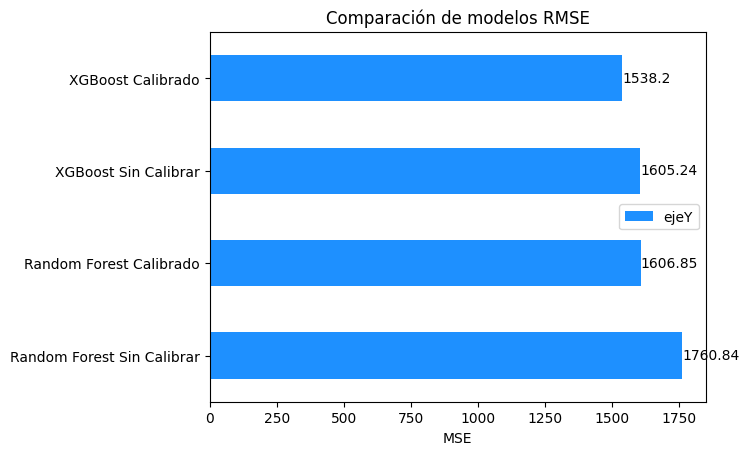

In [ ]:
 plot_barh(
    df=pd.DataFrame({'ejeX': ejeX, 'ejeY': [MSEXGB**(1/2),XGb_sin_mse**(1/2), rmse_rfreg, rmse_rfregt]}),
    title='Comparación de modelos RMSE',
    xlabel='MSE'
)

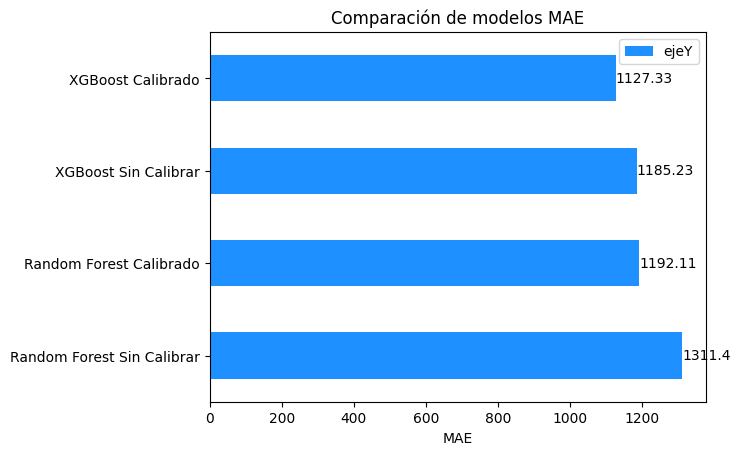

In [ ]:
plot_barh(
    df=pd.DataFrame({'ejeX': ejeX, 'ejeY': [MAEXGB, XGb_sin_mae ,mae_rfreg, mae_rfregt]}),
    title=r'Comparación de modelos MAE',
    xlabel='MAE'
)

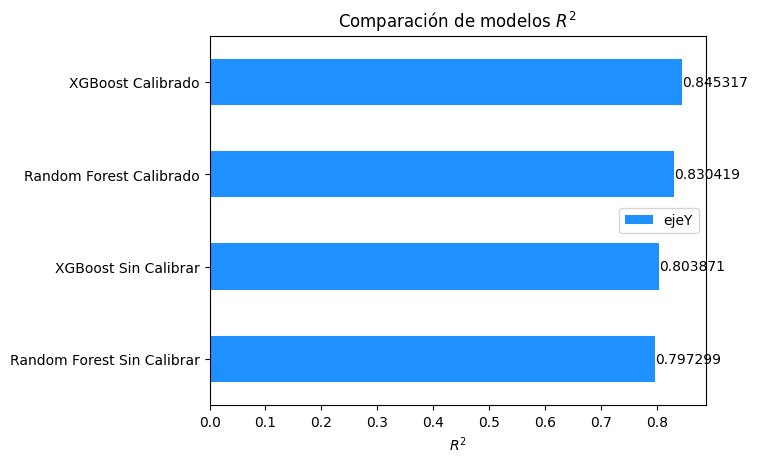

In [ ]:
plot_barh(
    df=pd.DataFrame({'ejeX': ejeX, 'ejeY': [r2XGB, XGb_sin_r2, r2_rfreg ,r2_rfregt]}),
    title=r'Comparación de modelos $R^2$',
    xlabel=r'$R^2$',
    asc=True
)

Los resultados revelan que el modelo XGBoost Calibrado supera a los otros modelos en términos de precisión, como se evidencia por sus valores más bajos de RMSE y MAE. Esto sugiere que las predicciones de este modelo tienden a estar más cerca de los valores reales en comparación con los otros modelos. Este hallazgo resalta la importancia de la calibración en la mejora del rendimiento de los modelos de aprendizaje automático, ya que el XGBoost Sin Calibrar muestra un desempeño ligeramente inferior.

Por otro lado, es interesante notar que, a pesar de las diferencias en los errores absolutos y cuadráticos medios entre los modelos XGBoost y Random Forest, todos los modelos exhiben valores de $R2$ bastante similares. Este coeficiente indica que, en conjunto, los modelos explican una cantidad similar de variabilidad en los datos. Sin embargo, es esencial tener en cuenta que el $R2$ no es la única métrica a considerar al evaluar el rendimiento de un modelo, ya que puede ser insensible a ciertos aspectos del ajuste del modelo, como el sesgo y la heterocedasticidad. En general, estos resultados resaltan la importancia de evaluar múltiples métricas de rendimiento para obtener una comprensión completa del desempeño de los modelos de aprendizaje automático.
